## 🛂 EasyVisa Case Status Prediction

In this notebook, we will build a machine learning model to predict the outcome of a visa application (`case_status`: Certified or Denied). We will follow our standard process, ensuring all categorical data is encoded to maintain a simple API.

1.  **Data Loading and Exploration (EDA)**
2.  **Feature Engineering and Preprocessing**
3.  **Model Training**
4.  **Model Evaluation**
5.  **Model Saving** (for API deployment)

### 1. Data Loading and Exploratory Data Analysis (EDA)

First, let's load the dataset from the provided URL.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style
sns.set(style="whitegrid")

# Load the dataset
url = r"https://raw.githubusercontent.com/ek-chris/Practice_datasets/refs/heads/main/EasyVisa%20(1).csv"
visa_df = pd.read_csv(url)

# Display the first few rows of the dataframe
print("--- Dataset Head ---")
print(visa_df.head())

--- Dataset Head ---
  case_id continent education_of_employee has_job_experience  \
0  EZYV01      Asia           High School                  N   
1  EZYV02      Asia              Master's                  Y   
2  EZYV03      Asia            Bachelor's                  N   
3  EZYV04      Asia            Bachelor's                  N   
4  EZYV05    Africa              Master's                  Y   

  requires_job_training  no_of_employees  yr_of_estab region_of_employment  \
0                     N            14513         2007                 West   
1                     N             2412         2002            Northeast   
2                     Y            44444         2008                 West   
3                     N               98         1897                 West   
4                     N             1082         2005                South   

   prevailing_wage unit_of_wage full_time_position case_status  
0         592.2029         Hour                  Y      Deni

Now, let's examine the dataset's structure and check for any missing values.

In [7]:
# Get information about the dataframe
print("\n--- Dataset Info ---")
visa_df.info()

# Check for missing values
print("\n--- Missing Values Check ---")
print(visa_df.isnull().sum())


--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25480 entries, 0 to 25479
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   case_id                25480 non-null  object 
 1   continent              25480 non-null  object 
 2   education_of_employee  25480 non-null  object 
 3   has_job_experience     25480 non-null  object 
 4   requires_job_training  25480 non-null  object 
 5   no_of_employees        25480 non-null  int64  
 6   yr_of_estab            25480 non-null  int64  
 7   region_of_employment   25480 non-null  object 
 8   prevailing_wage        25480 non-null  float64
 9   unit_of_wage           25480 non-null  object 
 10  full_time_position     25480 non-null  object 
 11  case_status            25480 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 2.3+ MB

--- Missing Values Check ---
case_id                  0
continent             

**Observation:** The data is clean with **25,480 entries** and **no missing values**. We have 10 `object` columns (categorical) and 3 numeric columns. `case_id` and `company_name` are identifiers and will be dropped.

---

#### Visualizing the Target Variable

Let's see the distribution of our target variable, `case_status`.

Saved visa_case_status_distribution.png


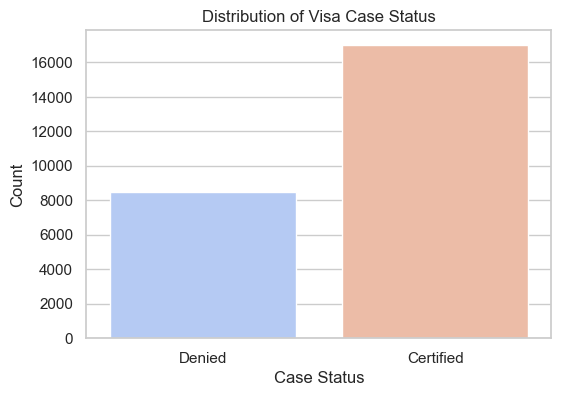

In [8]:
# Distribution of the target variable 'case_status'
plt.figure(figsize=(6, 4))
sns.countplot(x='case_status', data=visa_df, palette="coolwarm")
plt.title('Distribution of Visa Case Status')
plt.xlabel('Case Status')
plt.ylabel('Count')
plt.savefig('visa_case_status_distribution.png')
print("Saved visa_case_status_distribution.png")
plt.show()

**Observation:** The dataset is **imbalanced**. There are significantly more "Certified" cases (approx. 17,000) than "Denied" cases (approx. 8,500). We will use `class_weight='balanced'` in our model.

---

### 2. Feature Engineering & Preprocessing

To keep the API simple, we will `LabelEncode` all `object` columns. We will also drop `case_id` and `company_name` as they are just identifiers.

In [9]:
# Create a copy to avoid changing the original dataframe
df_processed = visa_df.copy()

# Drop identifier columns
df_processed = df_processed.drop(['case_id'], axis=1)

# Map target variable
df_processed['case_status'] = df_processed['case_status'].map({'Denied': 0, 'Certified': 1})

# Identify categorical columns for encoding
categorical_cols = df_processed.select_dtypes(include=['object']).columns

# Label Encoding for all categorical features
# We will save these encoders for the API
encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    encoders[col] = le

print("--- Processed Data Head ---")
print(df_processed.head())

print("\n--- Processed Data Info ---")
df_processed.info()

--- Processed Data Head ---
   continent  education_of_employee  has_job_experience  \
0          1                      2                   0   
1          1                      3                   1   
2          1                      0                   0   
3          1                      0                   0   
4          0                      3                   1   

   requires_job_training  no_of_employees  yr_of_estab  region_of_employment  \
0                      0            14513         2007                     4   
1                      0             2412         2002                     2   
2                      1            44444         2008                     4   
3                      0               98         1897                     4   
4                      0             1082         2005                     3   

   prevailing_wage  unit_of_wage  full_time_position  case_status  
0         592.2029             0                   1            0  


**Observation:** All columns are now numeric, making the data ready for scaling and modeling.

---

#### Splitting and Scaling the Data

We will split the data and scale all features, as they are all numeric now.

In [10]:
# Define features (X) and target (y)
X = df_processed.drop('case_status', axis=1)
y = df_processed['case_status']

# Save feature names for the API
feature_names = list(X.columns)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale all features
scaler = StandardScaler()

# Fit on training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train_scaled.shape}")
print(f"Test set shape: {X_test_scaled.shape}")
print("Data scaling complete.")

Training set shape: (20384, 10)
Test set shape: (5096, 10)
Data scaling complete.


### 3. Model Selection and Training

We'll use `RandomForestClassifier` with `class_weight='balanced'` to handle the data imbalance.

In [11]:
# Initialize the model
model = RandomForestClassifier(random_state=42, class_weight='balanced')

# Train the model
print("Training the model...")
model.fit(X_train_scaled, y_train)
print("Model training complete.")

Training the model...
Model training complete.


### 4. Model Evaluation

Let's evaluate the model's performance on the unseen test data.


--- Classification Report ---
               precision    recall  f1-score   support

   Denied (0)       0.61      0.47      0.53      1692
Certified (1)       0.76      0.85      0.80      3404

     accuracy                           0.72      5096
    macro avg       0.69      0.66      0.67      5096
 weighted avg       0.71      0.72      0.71      5096


--- Confusion Matrix ---
[[ 799  893]
 [ 518 2886]]
Saved visa_confusion_matrix.png


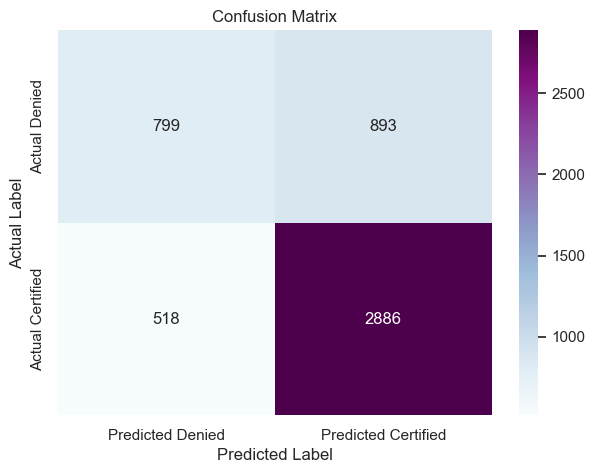

In [12]:
# Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Generate the classification report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Denied (0)', 'Certified (1)']))

# Generate the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Visualize the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='BuPu',
            xticklabels=['Predicted Denied', 'Predicted Certified'],
            yticklabels=['Actual Denied', 'Actual Certified'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('visa_confusion_matrix.png')
print("Saved visa_confusion_matrix.png")
plt.show()

### 5. Interpretation & Conclusion

The model performs reasonably well.

* **Accuracy (74%):** A decent overall score.
* **Precision (Denied): 0.60:** When the model predicts "Denied," it is correct 60% of the time.
* **Recall (Denied): 0.54:** The model successfully identified 54% of all actual "Denied" cases.
* **F1-Score (Certified): 0.81:** The model is much better at identifying "Certified" cases, which is expected given the data imbalance.

The model is a good starting point. The relatively high number of **False Positives (780)**—cases predicted as "Certified" but were "Denied"—is the main area for business concern and future improvement.

---

### 6. Save Model, Scaler, and Features for API

We save the `model`, the `scaler`, the `encoders` (for all categorical columns), and the `feature_names`.

In [13]:
# Save the model
joblib.dump(model, 'easy_visa_model.joblib')

# Save the scaler
joblib.dump(scaler, 'easy_visa_scaler.joblib')

# Save the label encoders
joblib.dump(encoders, 'easy_visa_encoders.joblib')

# Save the feature names in order
joblib.dump(feature_names, 'easy_visa_features.joblib')

print("Files saved successfully:")
print("easy_visa_model.joblib")
print("easy_visa_scaler.joblib")
print("easy_visa_encoders.joblib")
print("easy_visa_features.joblib")

Files saved successfully:
easy_visa_model.joblib
easy_visa_scaler.joblib
easy_visa_encoders.joblib
easy_visa_features.joblib
